<a target="_blank" href="https://colab.research.google.com/github/dtu-act/Adv_Acoustics_ML_module.git"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# uncomment the following line if you are running this notebook in Google Colab
# !pip install pyroomacoustics

# Advanced Acoustics (34860) - Machine Learning in Acoustics Module

Date: April 27 2023
Author: Xenofon Karakonstantis
Special thanks to: Rahul Roy Chowdhury who inspired this 'minilecture' due to his excellent work in his special course on acoustic source localization.


This is a minilecture on machine learning in acoustics. There won't be much of a lecture but rather a tutorial on how to use machine learning to solve a problem in acoustics. The problem we will be solving is the localization of a sound source in a room. First you will be 'gently' introduced to python and a few key libraries that we will be using. Then you will be introduced to the problem and the data we will be using. Finally, you will be introduced to the machine learning model we will be using and how to train it. Hopefully by the end of this notebook you will have a good idea of how to use machine learning to solve a problem in acoustics.

The contents of this notebook are outlined below:

1. Python/Jupyter Review
2. Imports, Packages, and Modules
3. The Problem
4. The Data
5. The Model
6. Training the Model
7. Evaluating the Model
8. Conclusion
9. References



## Python/Jupyter Review
This lecture assumes some "basic" familiarity with Python (cf. "Learn the Basics" at LearnPython.org). However, it's not a "Python 101" course, so we won't be spending much time on the basics.

Key Points About Python
* Python is an interpreted language (vs. compiled)
* Python is dynamically typed (vs. statically typed)
* Python is an object-oriented language (vs. functional)
* Python is a high-level language (vs. low-level)
* Python is a general-purpose language (vs. domain-specific)
* and more...
* Python is a great language for engineering!

What is Jupyter?
* Jupyter is a web-based interactive development environment for creating Jupyter notebooks
* Jupyter notebooks are documents that contain a mix of computer code (e.g., Python) and rich text elements (paragraphs, equations, figures, links, etc.)
* Jupyter notebooks are an excellent tool for data science, scientific computing, and machine learning

What about Google Colab?
* Google Colab is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud
* Google Colab is a great tool for learning Python and Jupyter
* Google Colab is a great tool for collaborating on Jupyter notebooks

## Imports, Packages, and Modules

In python, we can import packages and modules to extend the functionality of the language. For example, we can import the `math` package to use the `sqrt` function.

In [1]:
import math

In [2]:
math.sqrt(4)

2.0

For this lecture we will be using a few basic packages, as well as a few packages that are specific to this lecture.

### Imports those packages please

In [1]:
# Imports
from __future__ import absolute_import, division, print_function, unicode_literals
# hide tensorflow warnings
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings

warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import pyroomacoustics as pra
import IPython.display as ipd
from tqdm import tqdm  # Progress bar
from sklearn.utils import shuffle
from mpl_toolkits.mplot3d import Axes3D

try:
    # %tensorflow_version only exists in Colab.
    % tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow import keras

plt.style.use('seaborn')
# set random seed
tf.random.set_seed(42)
np.random.seed(42)
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.10.0


### Auxiliary Fuctions (hidden)

Below are some auxiliary functions that we will be using throughout the lecture. You can ignore them for now, but feel free to take a look at them if you are interested and/or want to change something, but be careful not to break anything.

In [154]:
def sph2cart(azimuth, colatitude, r):
    """Spherical to cartesian coordinate transform.
    Parameters
    ----------
    azimuth : float or array_like
            Azimuth angle in radiants
    colatitude : float or array_like
            Colatitude angle in radiants (with 0 denoting North pole)
    r : float or array_like
            Radius

    Returns
    -------
    x : float or `numpy.ndarray`
        x-component of Cartesian coordinates
    y : float or `numpy.ndarray`
        y-component of Cartesian coordinates
    z : float or `numpy.ndarray`
        z-component of Cartesian coordinates

    """
    x = r * np.cos(azimuth) * np.sin(colatitude)
    y = r * np.sin(azimuth) * np.sin(colatitude)
    z = r * np.cos(colatitude)
    return x, y, z


def cart2sph(x, y, z):
    r"""Cartesian to spherical coordinate transform.
    Parameters
    ----------
    x : float or array_like
        x-component of Cartesian coordinates
    y : float or array_like
        y-component of Cartesian coordinates
    z : float or array_like
        z-component of Cartesian coordinates
    Returns
    -------
    theta : float or `numpy.ndarray`
            Azimuth angle in radians
    phi : float or `numpy.ndarray`
            Colatitude angle in radians (with 0 denoting North pole)
    r : float or `numpy.ndarray`
            Radius
    """
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = np.arctan2(y, x)
    phi = np.arccos(z / r)
    return theta, phi, r


def room_volume_check(room_dim, room_volume):
    # check if room volume is within 10% of desired volume and if room height is lower than 5.5 m
    if room_volume - 0.2 * room_volume <= np.prod(room_dim) <= room_volume + 0.2 * room_volume and room_dim[2] < 5.5:
        return True
    else:
        return False


def source_pos_check(room_dim, source_pos):
    # check if source is at least 0.1 m from walls
    if np.all(source_pos > 0.1) and np.all(source_pos < room_dim - 0.1):
        return True
    else:
        return False


def get_random_source_pos(room_dim, receiver_coords, distance_from_receiver=1.5, s_azi=0.):
    # vector from origin to receivers
    receivers_center = np.mean(receiver_coords, axis=1)
    # centered_receivers = receiver_coords - receivers_center[:, np.newaxis]
    # find random source position that is at least distance_from_receiver m from receiver and azimuth is at s_azi from mic 1 (in radians)
    # vector to mic 1
    # mic1 = centered_receivers[:, 0]
    # place source s_azi radians from mic 1
    s_ele = np.random.uniform(np.pi / 4, 3 * np.pi / 4)  # 0 is north pole and pi is south pole
    s_pos = distance_from_receiver * np.r_[np.cos(s_azi) * np.sin(s_ele), np.sin(s_azi) * np.sin(s_ele),
                                                     np.cos(s_ele)]

    # s_pos = np.array(sph2cart(s_azi, s_ele, distance_from_receiver))
    # find azimuth angle between mic1 and s_pos vectors
    s_pos = s_pos + receivers_center
    # check if source is at least 0.1 m from walls
    if source_pos_check(room_dim, s_pos):
        return s_pos, s_azi
    else:
        return get_random_source_pos(room_dim, receivers_center, distance_from_receiver)


def adjustSNR(sig, noise=None, snrdB=40):
    """
    Add zero-mean, Gaussian, additive noise for specific SNR
    to input signal

    Parameters
    ----------
    sig : Tensor
        Original Signal.
    noise : Vector or Tensor, optional
        Noise Tensor. The default is None.
    snrdB : int, optional
        Signal to Noise ratio. The default is 40.

    Returns
    -------
    x : Tensor
        Noisy Signal.

    """
    if noise == None:
        # zero-mean, Gaussian, additive noise
        noise = np.random.normal(0., 1., sig.shape)
    # Power of target and noise signal (remove DC)
    energyTarget = np.mean((sig - np.mean(sig)) ** 2)
    energyNoise = np.mean((noise - np.mean(noise)) ** 2)
    # Calculate scaling factor to achieve desired SNR
    scalingFactor = np.sqrt(energyTarget / (energyNoise * (10 ** (snrdB / 10))))
    # Add noise to target
    x = sig + scalingFactor * noise
    return x


def plot_source_receiver_config(source_coords, receiver_coords):
    # vector from source to receivers
    v = receiver_coords - source_coords[:, np.newaxis]
    # vector from source to center of receivers
    v_center = np.mean(v, axis=1)
    # center receivers at origin
    receiver_coords = receiver_coords - v_center[:, np.newaxis]
    # center source at origin
    source_coords = source_coords - v_center[:, np.newaxis]
    # plot source and receivers
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(source_coords[0], source_coords[1], source_coords[2], c='r', marker='o', label='source')
    ax.scatter(receiver_coords[0], receiver_coords[1], receiver_coords[2], c='b', marker='o', label='receiver')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    plt.show()


def plot_room_edges(room_dim, ax=None):
    # Plot the edges
    if ax == None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    room_dim = np.array([
        [0, 0, 0],
        [0, 0, room_dim[2]],
        [0, room_dim[1], 0],
        [0, room_dim[1], room_dim[2]],
        [room_dim[0], 0, 0],
        [room_dim[0], 0, room_dim[2]],
        [room_dim[0], room_dim[1], 0],
        [room_dim[0], room_dim[1], room_dim[2]]])
    # Plot the corners
    ax.scatter(room_dim[:, 0], room_dim[:, 1], room_dim[:, 2], c='k')
    # Plot the edges
    edges = [
        (0, 1), (0, 2), (0, 4), (1, 3),
        (1, 5), (2, 3), (2, 6), (3, 7),
        (4, 5), (4, 6), (5, 7), (6, 7)
    ]
    for edge in edges:
        ax.plot(room_dim[edge, 0], room_dim[edge, 1], room_dim[edge, 2], c='black')

    # Set the limits and labels
    ax.set_xlim([np.min(room_dim[:, 0]), np.max(room_dim[:, 0])])
    ax.set_ylim([np.min(room_dim[:, 1]), np.max(room_dim[:, 1])])
    ax.set_zlim([np.min(room_dim[:, 2]), np.max(room_dim[:, 2])])
    # set aspect ratio to 1:1:1
    ax.set_box_aspect((1, 1, 1))
    ax.view_init(elev=30, azim=30)
    return ax


def random_azimuth_rotation(v, azi):
    # rotate vector v in xy plane by azi radians
    # v is coordinate vector (3 x M) where M is number of points
    # azi is azimuth angle in radians
    R = np.array([[np.cos(azi), -np.sin(azi), 0],
                  [np.sin(azi), np.cos(azi), 0],
                  [0, 0, 1]])
    v_center = np.mean(v, axis=1)
    v = v - v_center[:, np.newaxis]
    v_rot = np.matmul(R, v)
    v_rot = v_rot + v_center[:, np.newaxis]
    return v_rot


def plot_room_and_array(room_dim, source_coords, r):
    # set font size for plots
    plt.rcParams.update({'font.size': 20})
    mic_center = np.mean(r, axis=1)
    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1 = plot_room_edges(room_dim, ax1)
    ax1.scatter(source_coords[0], source_coords[1], source_coords[2], c='r', marker='o', label='source', s=100)
    ax1.scatter(r[0], r[1], r[2], c='b', marker='x', label='receivers', s=30)
    ax1.set_xlabel('x (m)')
    ax1.set_ylabel('y (m)')
    ax1.set_zlabel('z (m)')
    ax1.view_init(elev=45, azim=30)
    ax1.legend()
    # Define the vertices of the rectangle
    # Set the limits of the axes to zoom in on the region spanned by the receivers
    x_min, x_max = np.min(r[0]) - 0.1, np.max(r[0]) + 0.1
    y_min, y_max = np.min(r[1]) - 0.1, np.max(r[1]) + 0.1
    z_min, z_max = np.min(r[2]) - 0.1, np.max(r[2]) + 0.1
    # define cube vertices to plot around array
    cube_vertices = [
        (x_min, y_min, z_min), (x_min, y_min, z_max),
        (x_min, y_max, z_min), (x_min, y_max, z_max),
        (x_max, y_min, z_min), (x_max, y_min, z_max),
        (x_max, y_max, z_min), (x_max, y_max, z_max)
    ]
    # define cube edges
    cube_edges = [
        (0, 1), (0, 2), (0, 4), (1, 3), (1, 5), (2, 3),
        (2, 6), (3, 7), (4, 5), (4, 6), (5, 7), (6, 7)
    ]
    # plot cube edges
    for edge in cube_edges:
        ax1.plot([cube_vertices[edge[0]][0], cube_vertices[edge[1]][0]],
                 [cube_vertices[edge[0]][1], cube_vertices[edge[1]][1]],
                 [cube_vertices[edge[0]][2], cube_vertices[edge[1]][2]],
                 c='k', alpha=0.3, linewidth=2)
    # Plot the zoomed-in 3D scatter plot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(source_coords[0], source_coords[1], source_coords[2], c='r', marker='o', label='source', s=100)
    ax2.scatter(r[0], r[1], r[2], c='b', marker='x', label='receivers', s=30)
    ax2.set_xlabel('x (m)')
    ax2.set_ylabel('y (m)')
    ax2.set_zlabel('z (m)')
    ax2.view_init(elev=45, azim=30)
    ax2.legend()
    # Set the limits of the axes to zoom in on the region spanned by the receivers
    ax2.set_xlim([x_min, x_max])
    ax2.set_ylim([y_min, y_max])
    ax2.set_zlim([z_min, z_max])
    # plot an arrow from the microphone array center to the source in both plots
    ax1.quiver(mic_center[0], mic_center[1], mic_center[2],
               source_coords[0] - mic_center[0],
               source_coords[1] - mic_center[1],
               source_coords[2] - mic_center[2],
               color='k', arrow_length_ratio=0.3)
    ax2.quiver(mic_center[0], mic_center[1], mic_center[2],
               source_coords[0] - mic_center[0],
               source_coords[1] - mic_center[1],
               source_coords[2] - mic_center[2],
               color='k', arrow_length_ratio=0.3)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3)
    plt.show()


def azimuth_to_one_hot_encoding(azimuth, angular_resolution=30):
    # convert azimuth to one-hot encoding
    # azimuth is in radians
    # angular_resolution is in degrees
    # returns a one-hot encoding of the azimuth
    # e.g. if angular_resolution = 30, then the one-hot encoding is a vector of length 12
    # the index of the 1 in the vector corresponds to the azimuth
    # convert azimuth to degrees
    azimuth_deg = np.rad2deg(azimuth)
    # convert azimuth to index
    azimuth_index = int(azimuth_deg // angular_resolution)
    # create one-hot encoding
    one_hot_encoding = np.zeros(360 // angular_resolution)
    one_hot_encoding[azimuth_index] = 1
    return one_hot_encoding


def one_hot_encoding_to_azimuth(encoding, angular_resolution=30):
    # convert one-hot encoding to azimuth
    # encoding is a one-hot encoding of the azimuth
    # angular_resolution is in degrees
    # returns the azimuth in radians
    # convert encoding to index
    azimuth_index = np.argmax(encoding)
    N_classes = 360 // angular_resolution
    azimuth_class_lims = np.arange(0, 360 + angular_resolution, angular_resolution)
    # create tuple with lower and upper limits of each class
    azimuth_class_lims = [(azimuth_class_lims[i], azimuth_class_lims[i + 1]) for i in range(N_classes)]
    azimuth_deg = np.mean(azimuth_class_lims[azimuth_index])
    return azimuth_deg


def get_random_azimuth_angle(class_no, angular_resolution=30):
    # create equally spaced azimuth angle classes in radians
    N_classes = 360 // angular_resolution
    azimuth_class_lims = np.arange(0, 360 + angular_resolution, angular_resolution)
    # create tuple with lower and upper limits of each class
    azimuth_class_lims = [(azimuth_class_lims[i], azimuth_class_lims[i + 1]) for i in range(N_classes)]
    # randomly sample azimuth angle from class
    return np.deg2rad(np.random.uniform(azimuth_class_lims[class_no][0], azimuth_class_lims[class_no][1]))


def get_random_ISM_RIRs(room_volume=150,  # m^3
                        fs=16000,  # Hz
                        rt60_median=0.4,  # s
                        max_order=9,  # reflections (image sources)
                        source_distance=1.5,  # m,
                        source_azimuth=0.,  # rad
                        plot_RIR=False,
                        plot_room=False,
                        plot_array=False,
                        raytrace=False,
                        snr=45,  # dB (signal-to-noise ratio)
                        d=0.04):  # Diameter of the microphone array (m)
    # find random room dimensions that fit within the volume
    # room dimensions (corner distance from origin in [x,y,z] meters)
    room_dim = np.random.uniform(3, 10, 3)
    not_suitable = True
    while not_suitable:
        room_dim = np.random.uniform(3, 7, 3)
        not_suitable = not room_volume_check(room_dim, room_volume)
    # receiver centre coords
    mic_center = [room_dim[0] / 2, room_dim[1] / 2, 1.5]
    r = np.array([[mic_center[0] + d / 2, mic_center[1], mic_center[2]],
                  [mic_center[0], mic_center[1] + d / 2, mic_center[2]],
                  [mic_center[0] - d / 2, mic_center[1], mic_center[2]],
                  [mic_center[0], mic_center[1] - d / 2, mic_center[2]]]).T

    # apply random azimuth rotation to array and source
    theta = np.random.uniform(0, 2 * np.pi)
    r = random_azimuth_rotation(r, theta)

    # source position at source_distance (m) from centre of array and at source_azimuth (rad)
    source_coords, doa = get_random_source_pos(room_dim, r, source_distance, source_azimuth)

    # plot 3d array
    if plot_room:
        plot_room_and_array(room_dim, source_coords, r)
    # room properties
    # set uniform absorption coeffs to walls within 10% of median T60 value
    rt60 = np.random.uniform(rt60_median - 0.1, rt60_median + 0.1)
    e_absorption, _ = pra.inverse_sabine(rt60, room_dim)
    # Create the room
    room = pra.ShoeBox(
        room_dim,
        fs=fs,
        materials=pra.Material(e_absorption),
        max_order=max_order,
        ray_tracing=raytrace,
        air_absorption=True)
    # add source to room
    room.add_source(source_coords)
    # add arrays to room
    room.add_microphone_array(r)
    # compute RIR
    room.compute_rir()
    trunc = 5000
    # split the arrays
    rir_size = len(room.rir)
    RIRs = np.zeros((rir_size, trunc))
    for ii in range(len(room.rir)):
        RIRs[ii, :] = np.hstack((room.rir[ii][0], np.zeros((trunc - len(room.rir[ii][0], )))))
    # time samples
    t = np.linspace(0, trunc / fs, trunc)
    if plot_RIR:
        fig, ax = plt.subplots(1, 1)
        ax.plot(t[:int(0.2 * fs)], RIRs[:3, :int(0.2 * fs)].T)
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Amplitude')
        ax.grid('both', ls=':', color='k')
        ax.set_title('Generated ISM RIRs')
        plt.show()
    # add white noise to RIRs
    RIRs = adjustSNR(RIRs, snrdB=snr)
    if plot_array:
        # source position in polar plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='polar')
        ax.set_theta_zero_location("N")
        # set zero angle to be at mic1
        ax.set_theta_direction(-1)
        ax.set_rlim(0, 2.)
        ax.set_rticks([0.5, 1, 1.5, 2.])
        ax.set_rlabel_position(0)
        ax.set_title('DOA = {:.4} deg'.format(str(np.rad2deg(doa))))
        ax.plot(doa, 1.5, 'ro')
        ax.plot(np.deg2rad(0), .5, 'bo')
        ax.plot(np.deg2rad(90), .5, 'bo')
        ax.plot(np.deg2rad(180), .5, 'bo')
        ax.plot(np.deg2rad(270), .5, 'bo')
        # plot circle at with array diameter
        ax.grid(True)
        fig.tight_layout()
        fig.show()

    # return dictionary of room parameters
    room_params = {
        'room_dim': room_dim,
        'rt60': rt60,
        'mic_coords': r,
        'mic_center': mic_center,
        'source_coords': source_coords,
        'RIRs': RIRs,
        'fs': fs,
        'trunc': trunc,
        'doa': doa,
        't': t}
    return room_params

def calc_scm(X):
    # X (n_freq,n_channels,n_timesteps) OR (n_freq,n_channels,n_snapshots,n_timesteps)
    if X.ndim == 4:
        return np.einsum('fnst,fmst->fnmt', X, np.conj(X), optimize=True) / X.shape[2]
    elif X.ndim == 3:
        return np.einsum('fnt,fmt->fnmt', X, np.conj(X), optimize=True)
    else:
        return np.einsum('fn,fm->fnm', X, np.conj(X), optimize=True)


def srp_map(X, A, phat=False):
    """
    X (n_freq,n_channels,n_snapshots)
    A (n_freq,n_channels,n_grid_dirs)

    """
    AHA = np.einsum('fnd,fmd->fnmd', np.conj(A), A)
    if phat:  # apply PHAseTransform
        X = X / np.abs(X + 1e-13)
    if X.ndim == 2:
        SCM = calc_scm(X.T)
    else:
        SCM = calc_scm(X.transpose(1, 0, 2))
    if SCM.ndim == 3:
        SRP = np.real(np.einsum('fnm,fnmd->d', SCM, AHA, optimize=True))
    else:
        SRP = np.real(np.einsum('fnmt,fnmd->dt', SCM, AHA, optimize=True))
    SRP *= 2 / X.shape[0] / X.shape[1] / (X.shape[1] - 1)
    return SRP

def srpDOA(P, fs, r_mic, NFFT = 1024, c0=343., LookingDirections=None, return_degrees=True):
    """
    P (n_freq,n_channels,n_snapshots)
    fvec (n_freq,)
    r_mic (n_channels,3)
    c0 (scalar)
    LookingDirections (n_grid_dirs,3)
    """
    fvec = np.fft.rfftfreq(NFFT, 1. / fs)

    # check if P is complex
    if not np.iscomplexobj(P):
        P = np.fft.rfft(P, n=NFFT, axis=-1)
    if LookingDirections is None:
        # create unit circle looking directions
        theta = np.arange(0, 2 * np.pi, 0.01)
        LookingDirections = np.stack([np.cos(theta),
                                      np.sin(theta),
                                      np.zeros_like(theta)]).T
    k_abs = 2 * np.pi * fvec / c0
    A = np.exp(1j * np.einsum('i,jk,dk->ijd', k_abs, r_mic, LookingDirections))  # time delay at microphones
    powermap = srp_map(P, A, phat=True).astype(np.float32)
    if powermap.ndim == 2:
        powermap = powermap.sum(-1)
    doa_cart = LookingDirections[np.argmax(powermap)]
    doa_azi = np.arctan2(doa_cart[1], doa_cart[0])
    if return_degrees:
        doa_azi = np.rad2deg(doa_azi)
        if doa_azi < 0:
            doa_azi += 360
    return doa_azi

### Numpy and Tensorflow Review

*Numpy* is a package for scientific computing in Python. It provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more.

*Tensorflow* is an open source machine learning framework for everyone. We will be using it to build and train neural networks.

### Arrays in numpy
Numpy arrays are the main data structure we will be using, they have a lot of useful properties and methods. We will be using them to store our data and to perform operations on them. There are lots of ways to create arrays, but we will focus on the most common ones. For more information, see the [Numpy documentation](https://numpy.org/doc/stable/user/quickstart.html).
Some examples:


In [5]:
a = np.array([1, 2, 3, 4, 5, 6])
print(f'a = {a}')
b = np.arange(6)  # starts with 0, ends at 5
print(f'b = {b}')
print(f'c = {np.ones(10)}')
print(f'd = {np.zeros(7)}')
print(f"e = \n{np.eye(3)}")  # identity matrix "I" = "eye"
f = np.random.rand(4, 5)  # random numbers between 0 and 1: 4 rows, 5 columns
print(f'f = \n{f}')

a = [1 2 3 4 5 6]
b = [0 1 2 3 4 5]
c = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
d = [0. 0. 0. 0. 0. 0. 0.]
e = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
f = 
[[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
 [0.15599452 0.05808361 0.86617615 0.60111501 0.70807258]
 [0.02058449 0.96990985 0.83244264 0.21233911 0.18182497]
 [0.18340451 0.30424224 0.52475643 0.43194502 0.29122914]]


### Tensorflow Tensors

Similar to numpy arrays, tensorflow tensors are the main data structure we will be using for the ML part. They are similar to numpy arrays, but they can be used on a GPU, which makes them much faster. We will be using them to store our data and to perform operations on them. For more information, see the [Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf).
Some examples:

In [6]:
# Tensorflow Tensors
a = tf.constant([1, 2, 3, 4, 5, 6])
print(f'a = {a}')
b = tf.range(6)  # starts with 0, ends at 5
print(f'b = {b}')
print(f'c = {tf.ones(10)}')
print(f'd = {tf.zeros(7)}')
print(f"e = \n{tf.eye(3)}")  # identity matrix "I" = "eye"
f = tf.random.uniform((4, 5))  # random numbers between 0 and 1: 4 rows, 5 columns
print(f'f = \n{f}')

a = [1 2 3 4 5 6]
b = [0 1 2 3 4 5]
c = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
d = [0. 0. 0. 0. 0. 0. 0.]
e = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
f = 
[[0.6645621  0.44100678 0.3528825  0.46448255 0.03366041]
 [0.68467236 0.74011743 0.8724445  0.22632635 0.22319686]
 [0.3103881  0.7223358  0.13318717 0.5480639  0.5746088 ]
 [0.8996835  0.00946367 0.5212307  0.6345445  0.1993283 ]]


### Python loops

Python loops are very similar to loops in other languages. They are used to repeat a block of code a certain number of times. For more information, see the [Python documentation](https://docs.python.org/3/tutorial/controlflow.html#for-statements).

In [7]:
for i in range(5):
    print(i)

0
1
2
3
4


### Plotting

We will be using matplotlib to plot our data. For more information, see the [Matplotlib documentation](https://matplotlib.org/3.1.1/contents.html).

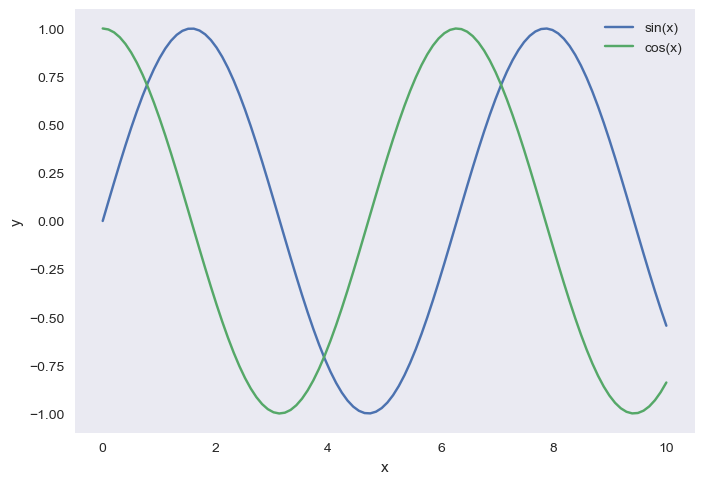

In [8]:
# Plotting
x = np.linspace(0, 10, 100)
plt.plot(x, np.sin(x), label='sin(x)')
plt.plot(x, np.cos(x), label='cos(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

## Deep Learning

### What is Deep Learning?

Deep learning is a subfield of machine learning concerned with algorithms inspired by the structure and function of the brain called artificial neural networks. Learning can be supervised, semi-supervised or unsupervised. Deep learning architectures such as deep neural networks, deep belief networks, recurrent neural networks and convolutional neural networks have been applied to fields including computer vision, speech recognition, natural language processing, audio recognition, social network filtering, machine translation, bioinformatics, drug design, medical image analysis, material inspection and board game programs, where they have produced results comparable to and in some cases superior to human experts.

In our case, we will be using deep learning to localize the sound source in a room. We will be using a neural network to predict the location of the sound source in a room, given the audio signal recorded by a microphone array.

Some material for deep learning:
* [Deep Learning Book](http://www.deeplearningbook.org/)
* [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book)
* [Deep Learning Course - DTU](https://kurser.dtu.dk/course/02456)
* [Deep Learning Course - MIT](http://introtodeeplearning.com/)

### Artificial Neural Networks (ANNs) or Multilayer Perceptrons (MLPs)

Artificial neural networks (ANNs) or multilayer perceptrons (MLPs) are computing systems vaguely inspired by the biological neural networks that constitute animal brains. Such systems "learn" to perform tasks by considering examples, generally without being programmed with any task-specific rules, namely by minimizing the empirical error between the output of the system and the desired output. They are usually trained using backpropagation.

A "neuron" is just a weighted sum of its inputs, with an activation function applied to the sum. The activation function is usually a non-linear function, such as the sigmoid function or the hyperbolic tangent function. The weights are adjusted during training, so that the neuron's output is closer to the desired output. The weights are adjusted by backpropagation, which is a method for computing the gradient of the error function with respect to the weights. The gradient is used to update the weights in the direction that reduces the error. The process is repeated until the error is small enough.
![Neuron of an ANN](./Assets/Neuron_edited.png "Neuron")


In deep learning, people tend to refer to a series of multiple neurons as a (fully connected) layer. The first layer is the input layer, the last layer is the output layer, and the layers in between are called hidden layers. The input layer is the layer that receives the input data. The output layer is the layer that produces the output data. However, a layer can also be comprised of convolutions or recurrent units, which are not neurons but are optimised all the same.

### Convolutional Neural Networks (CNNs)

Convolutional neural networks (CNNs) are a class of deep neural networks, most commonly applied to analyzing visual imagery. They are also known as shift invariant or space invariant artificial neural networks, based on their shared-weights architecture and translation invariance characteristics. In terms of acoustics, they are used to analyse audio signals or sound fields. They are also used in natural language processing, and are increasingly used in medical image analysis.

Convolutional layers use a set of learnable filters to scan over input data and extract features.

A convolution can be mathematically represented as
$$
(f * g)(t)=\int_{-\infty}^{\infty} f(\tau) g(t-\tau) d \tau,
$$
where $f$ and $g$ are functions, and $*$ denotes the convolution operation. In signal processing, this is known as the continuous convolution.

In discrete convolution used in deep learning, the equation becomes

$$
(f * g)[n]=\sum_{m=-\infty}^{\infty} f[m] g[n-m],
$$

where $f$ and $g$ are discrete sequences, and $[n]$ denotes the $n^{th}$ element of the sequence.

In the context of neural networks, we typically use convolutions with finite-length filters, so the sum over $m$ is finite. This is known as a finite impulse response (FIR) filter. The filter is slid over the input data, with the dot product of the filter coefficients and input data calculated at each position. This results in a new output sequence, which is used as input to the next layer of the network. The filter coefficients are learned during training.

![Convolutional layer](./Assets/conv.png "Convolutional layer")


## The Problem: Sound source localisation with 2 differential microphone arrays and a convolutional neural network

We will implementing the network from the 2021 paper titled [Deep learning assisted sound source localization using two orthogonal first-order differential microphone arrays](https://pubs.aip.org/asa/jasa/article/149/2/1069/600660/Deep-learning-assisted-sound-source-localization) by Liu et al. published in the Journal of the Acoustical Society of America. Make sure to have the paper open while reading this notebook.

The paper discusses the challenge of localizing sound sources in noisy and reverberant rooms using small microphone arrays. The authors propose a new method that uses deep learning and an improved feature extraction technique based on sound intensity estimation. They use a small-sized microphone array constructed by two orthogonal first-order differential microphone arrays to enhance spatial resolution. The proposed approach is shown to be superior to existing approaches in noisy and reverberant environments through extensive simulations and real-world experiments. The authors also highlight some of the limitations of previous approaches, such as sensitivity to additive noise and sensor mismatches (as you already know from the course), since this is one of the pitfalls of measuring the intensity with a proper probe also.

The authors essentially use a 4-channel microphone array which can be decomposed into two 2-channel microphone arrays. The two arrays are orthogonal to each other, and the microphones in each array are placed at a distance $d$ from each other. Below you can see a figure of the microphone array.

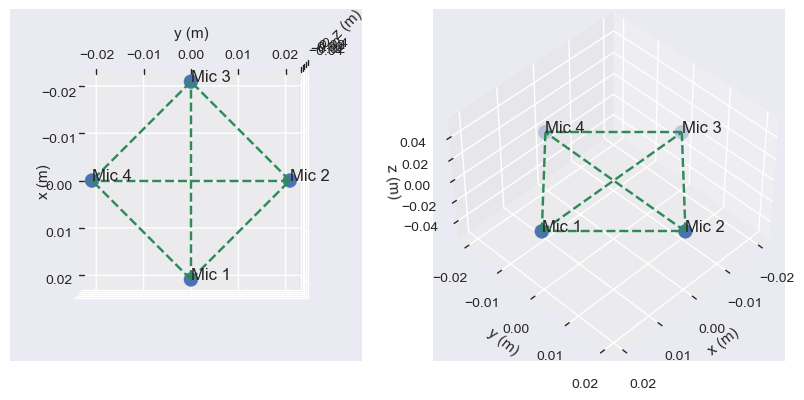

In [170]:
d = 0.04  # distance between microphones
r = np.array([[d / 2, 0, 0],
              [0, 0 + d / 2, 0],
              [0 - d / 2, 0, 0],
              [0, 0 - d / 2, 0]]).T
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(r[0, :], r[1, :], r[2, :], marker='o', s=100)
for i in range(4):
    for j in range(i + 1, 4):
        ax.plot([r[0, i], r[0, j]], [r[1, i], r[1, j]], [r[2, i], r[2, j]], linestyle='--', color='seagreen')
for i in range(4):
    ax.text(r[0, i], r[1, i], r[2, i], 'Mic {}'.format(i + 1), fontsize=12)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.view_init(azim=0, elev=90)
ax = fig.add_subplot(122, projection='3d')
ax.scatter(r[0, :], r[1, :], r[2, :], marker='o', s=100)
for i in range(4):
    for j in range(i + 1, 4):
        ax.plot([r[0, i], r[0, j]], [r[1, i], r[1, j]], [r[2, i], r[2, j]], linestyle='--', color='seagreen')
for i in range(4):
    ax.text(r[0, i], r[1, i], r[2, i], 'Mic {}'.format(i + 1), fontsize=12)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.view_init(azim=45, elev=45)
fig.show()

As per the paper, the proposed method utilises the intensity estimates by first obtaining the sound pressure and the particle velocity.
The sound pressure at the coordinate origin can be estimated by averaging the received signals from all microphones,  i.e.,
$$
p_0(t)=\left[p_1(t)+p_2(t)+p_3(t)+p_4(t)\right] / 4 .
$$
By the conservation of momentum, it follows that the component of particle velocity in a direction $r$ is related to the sound pressure by
$$
v_r(t)=-\frac{1}{\rho} \int_{-\infty}^t \frac{\partial p(\tau)}{\partial r} d \tau,
$$
where $v_r(t)$ is the particle velocity in the direction $r, p(t)$ is the sound pressure, and $\rho$ is the density of air. In practice, the pressure gradient in the previous equation can be approximated by a finite difference,  and thus this becomes
$$
v_r(t) \approx-\frac{1}{\rho \Delta r} \int_{-\infty}^t\left[p_{r_2}(\tau)-p_{r_1}(\tau)\right] d \tau,
$$

where $p_{r_2}$ and $p_{r_2}$ are the sound pressures measured at two closely spaced points along the direction $r$, and $\Delta r$ is the distance between the two points.

From this we can obtain the intensity estimates in the time-frequency domain as

$$
I_{0 x}(\omega, t)=P_0(\omega, t) V_x^{\star}(\omega, t)
$$
and
$$
I_{0 y}(\omega, t)=P_0(\omega, t) V_y^{\star}(\omega, t)
$$
where $P_0(\omega, t)$ is the short-time Fourier transform (STFT) of the sound pressure at the origin, and $V_x^{\star}(\omega, t)$ is the complex conjugate of the STFT of the particle velocity in the direction $x$ (and $y$ respectively).

The authors further decompose the intensity into more directional components by using different combinations of microphones of the original four-element orthogonal first-order DMAs into four independent three-element subarrays which allows them to obtain more directional information from the intensity estimates. All of the intensity components are combined into a single feature vector, which is then fed into a convolutional neural network (CNN) for sound source localization.

Part of your job is to code the equations from the paper in python, in order to extract the intensity estimates from the microphone signals. You will also need to code the CNN for sound source localization. Furthermore, you will need to simulate the room impulse responses (RIRs) for the microphone array, and then use the RIRs to simulate the microphone signals. Finally you will train the neural network and compare it to a baseline method for sound source localization.

## Simulate room impulse responses with the "Image Source Method"

## What is the Image Source Method?

The image source method (ISM) is a method for simulated the impulse response of a room. It is based on the assumption that the sound field in a room can be described as a superposition of waves originating from a set of virtual sources. The virtual sources are located at the image (mirror) sources of the real sources. The image sources are the points in the room that are the same distance from the real source as the real source is from the receiver. The impulse response is then calculated by summing the contributions of all the virtual sources.

This can be defined mathematically as
$$
h(t)=\sum_{i=1}^{N} \frac{1}{4 \pi r_{i}} \delta \left(t-\frac{r_{i}}{c}\right),

$$
where $h(t)$ is the impulse response, $N$ is the number of virtual sources, $r_i$ is the distance from the $i^{th}$ virtual source to the receiver, $\lambda$ is the wavelength, $c$ is the speed of sound, and $\delta(t)$ is the Dirac delta function. The impulse response is the sum of the contributions of all the virtual sources in a room assuming rigid walls, equivalent to the time domain Green's function for a room with rigid walls. In practice we also apply angle independent absorption to each wall, which is equivalent to adding a damping term to the Green's function.

To obtain the simulated data we will be using a python library called [pyroomacoustics]( https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.html).

For more information on the image method see:
  [1] De Sena, Enzo, et al. "On the modeling of rectangular geometries in room acoustic simulations." IEEE/ACM Transactions on Audio, Speech, and Language Processing 23.4 (2015): 774-786.
  [2] Allen, Jont B., and David A. Berkley. "Image method for efficiently simulating small‐room acoustics." The Journal of the Acoustical Society of America 65.4 (1979): 943-950.



## Simulate rooms with a single source

Here we will simulate the training data for the neural network training and validation. As previously described, this will be carried out with the ISM. Lets see an example of a simulated room with a single source.

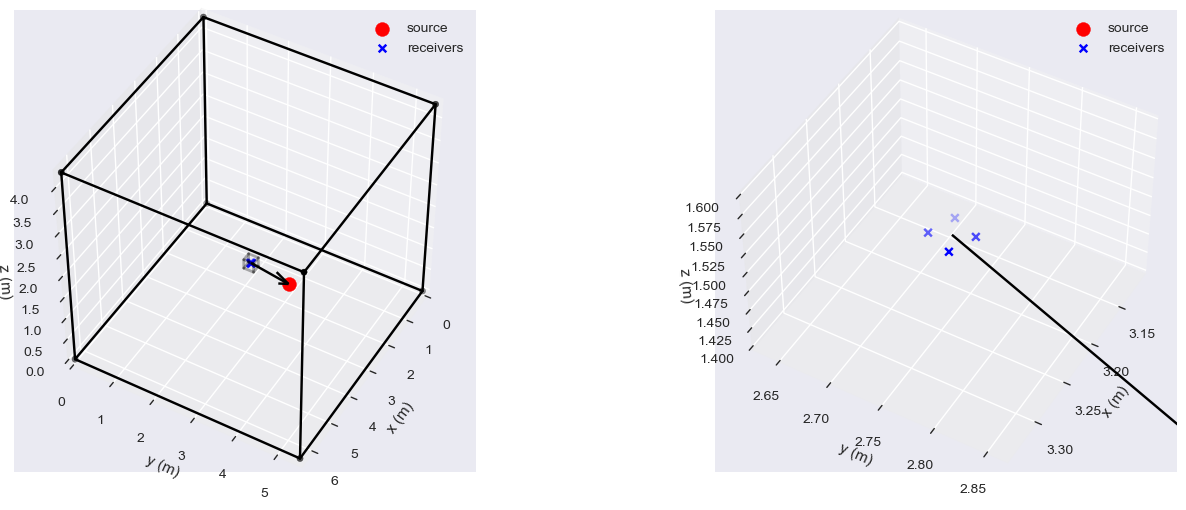

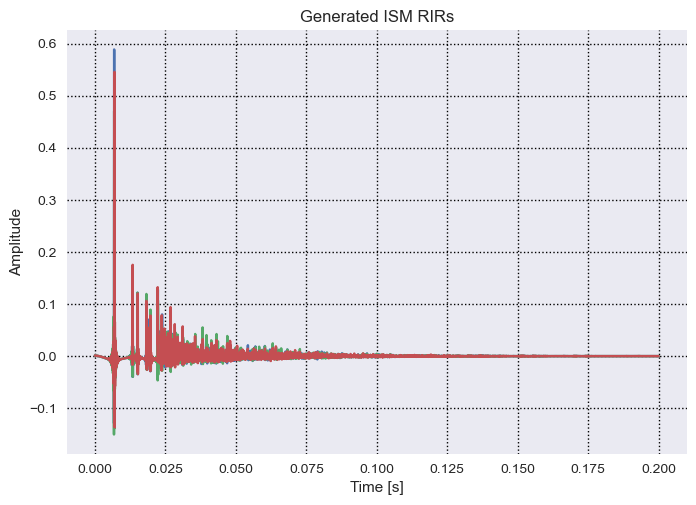

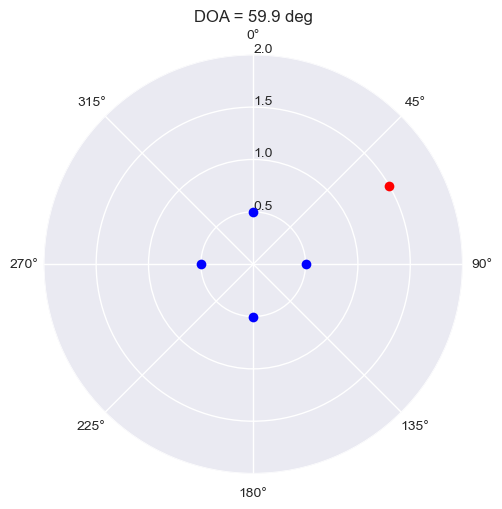

In [9]:
_ = get_random_ISM_RIRs(room_volume=150,  # m^3
                        fs=16000,  # Hz
                        rt60_median=0.3,  # s
                        max_order=11,  # reflections (order of image sources)
                        snr=45,  # dB Signal-to-noise ratio
                        source_distance=1.5,  # m
                        source_azimuth=np.pi / 3,  # radians relative to the x-axis (mic 1)
                        plot_RIR=True,
                        plot_room=True,
                        plot_array=True)

## Generate neural network data

In this section we will generate the data that will be used to train the neural network. We will generate a set of training data, a set of validation data, and a set of test data. The training data will be used to train the neural network, the validation data will be used to evaluate the performance of the neural network during training, and the test data will be used to evaluate the performance of the neural network after training. Below we will define the parameters for the data generation.

In [3]:
N_simulations_train = 2000  # number of simulations for training
N_simulations_valid = 600  # number of simulations for validation
N_simulations_test = 100  # number of simulations for testing
angular_resolution = 30  # Angular resolution of the network in degrees
N_classes = 360 // angular_resolution  # Number of classes
room_volume = 150  # m^3 (approximate volume of the simulated rooms)
fs = 16000  # Hz (sampling frequency)
rt60_median = 0.3  # s (median reverberation time)
max_order = 11  # (order of image sources)
snr = 45  # dB (Signal-to-noise ratio of generated RIRs)
source_distance = 1.5  # m (distance of the source from the array)
d = 0.04  # m (distance between the differential microphones)

### Training Data

In [12]:
N_sim_per_angle_train = N_simulations_train // N_classes
# create a vector of size N_simulations with the number of the class for each simulation
classes_train = np.repeat(np.arange(N_classes), N_sim_per_angle_train)
# make sure the vector has the correct size
while len(classes_train) < N_simulations_train:
    classes_train = np.append(classes_train, np.random.randint(N_classes))
# shuffle the vector
np.random.shuffle(classes_train)
pbar = tqdm(range(N_simulations_train))
rirs_train = []
T60_times = []
doa_encodings_train = []
for i in pbar:
    azim = get_random_azimuth_angle(classes_train[i], angular_resolution)
    data = get_random_ISM_RIRs(room_volume=room_volume,  # m^3
                               fs=fs,  # Hz
                               rt60_median=rt60_median,  # s
                               max_order=max_order,  # reflections (order of image sources)
                               snr=snr,  # dB Signal-to-noise ratio
                               source_distance=source_distance,  # m
                               source_azimuth=azim,
                               d=d)  # distance between the differential microphones

    rirs_train.append(data['RIRs'])
    T60_times.append(data['rt60'])
    doa_encodings_train.append(azimuth_to_one_hot_encoding(data['doa'], angular_resolution))
    # update progress bar
    pbar.set_description("Simulating room array response %i" % (i + 1))

# convert to numpy arrays
rirs_train = np.stack(rirs_train)
doa_encodings_train = np.stack(doa_encodings_train)

Simulating room array response 2000: 100%|██████████| 2000/2000 [04:06<00:00,  8.10it/s]


### Validation Data

In [13]:
N_sim_per_angle_valid = N_simulations_valid // N_classes
# create a vector of size N_simulations with the number of the class for each simulation
classes_valid = np.repeat(np.arange(N_classes), N_sim_per_angle_valid)
# make sure the vector has the correct size
while len(classes_valid) < N_simulations_valid:
    classes_valid = np.append(classes_valid, np.random.randint(N_classes))
# shuffle the vector
np.random.shuffle(classes_valid)
pbar = tqdm(range(N_simulations_valid))
rirs_valid = []
doa_encodings_valid = []
for i in pbar:
    azim = get_random_azimuth_angle(classes_valid[i], angular_resolution)
    data = get_random_ISM_RIRs(room_volume=room_volume,  # m^3
                               fs=fs,  # Hz
                               rt60_median=rt60_median,  # s
                               max_order=max_order,  # reflections (order of image sources)
                               snr=snr,  # dB Signal-to-noise ratio
                               source_distance=source_distance,  # m
                               source_azimuth=azim,
                               d=d)  # distance between the differential microphones

    rirs_valid.append(data['RIRs'])
    doa_encodings_valid.append(azimuth_to_one_hot_encoding(data['doa'], angular_resolution))
    # update progress bar
    pbar.set_description("Simulating room array response %i" % (i + 1))

# convert to numpy arrays
rirs_valid = np.array(rirs_valid)
doa_encodings_valid = np.array(doa_encodings_valid)

Simulating room array response 600: 100%|██████████| 600/600 [00:49<00:00, 12.00it/s]


### Test Data

In [164]:
N_sim_per_angle_test = N_simulations_test // N_classes
# create a vector of size N_simulations with the number of the class for each simulation
classes_test = np.repeat(np.arange(N_classes), N_sim_per_angle_test)
# make sure the vector has the correct size
while len(classes_test) < N_simulations_test:
    classes_test = np.append(classes_test, np.random.randint(N_classes))
pbar = tqdm(range(N_simulations_test))
rirs_test = []
doa_encodings_test = []
mic_positions = []
for i in pbar:
    azim = get_random_azimuth_angle(classes_test[i], angular_resolution)
    data = get_random_ISM_RIRs(room_volume=room_volume,  # m^3
                               fs=fs,  # Hz
                               rt60_median=rt60_median,  # s
                               max_order=max_order,  # reflections (order of image sources)
                               snr=snr,  # dB Signal-to-noise ratio
                               source_distance=source_distance,  # m
                               source_azimuth=azim,
                               d=d)  # distance between the differential microphones

    rirs_test.append(data['RIRs'])
    doa_encodings_test.append(azimuth_to_one_hot_encoding(data['doa'], angular_resolution))
    mic_positions.append(data['mic_coords'])
    # update progress bar
    pbar.set_description("Simulating room array response %i" % (i + 1))
# convert to numpy arrays
rirs_test = np.array(rirs_test)
doa_encodings_test = np.array(doa_encodings_test)
mic_positions = np.array(mic_positions)

Simulating room array response 100: 100%|██████████| 100/100 [00:10<00:00,  9.75it/s]


Let's plot the histogram of the T60 times of the simulated room impulse responses. We can see that the T60 times are distributed uniformly around 0.3 s. DOA algorithms are generally very sensitive to the T60 time, so in general higher T60 times will lead to worse performance. Furthermore, having a variety of T60 times in the training data will help the neural network to generalize better.

Text(0, 0.5, 'Density')

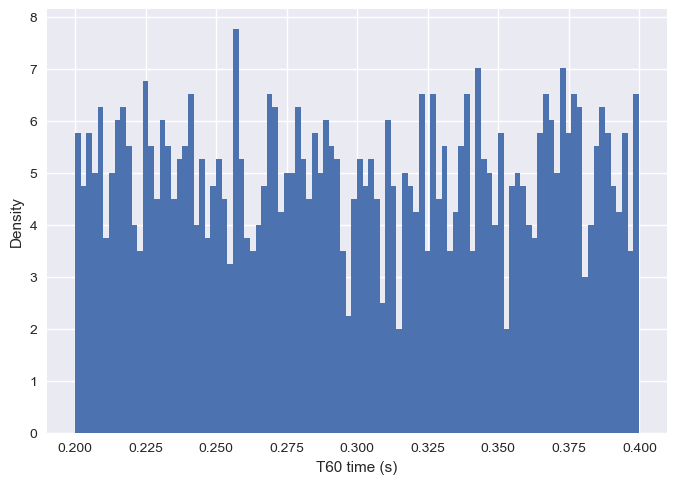

In [15]:
# plot histogram of T60 times
plt.hist(T60_times, bins=100, density=True)
plt.xlabel('T60 time (s)')
plt.ylabel('Density')

## Neural network data pre-processing

In this section we will emulate signals (i.e. speech) by convolving the simulated rirs with white noise. Generally, the neural network will be trained to predict the DOA of the source given the array response. However, in practice, the DOA is not directly available, but the array response is. Therefore, we will train the neural network to predict the DOA given the array signal.

In [9]:
def convolve_array_response_with_white_noise(array_response, fs=16000):
    array_sig = []
    white_noise = np.random.randn(int(0.15 * fs))
    # add between 0 s and 0.15 s of silence at the beginning and at the end randomly
    white_noise = np.concatenate((np.zeros(np.random.randint(0, int(0.15 * fs))), white_noise,
                                  np.zeros(np.random.randint(0, int(0.15 * fs)))))
    # pad to int(0.5 * fs) samples
    white_noise = np.pad(white_noise, (0, int(0.5 * fs) - len(white_noise)), 'constant')
    for rir in array_response:
        sig = np.convolve(rir, white_noise, mode='same')
        array_sig.append(sig)
    return array_sig

### Training Signals

In [17]:
fs = 16000  # Hz
signals_train = []
pbar = tqdm(range(N_simulations_train))
for i in pbar:
    signals_train.append(np.array(convolve_array_response_with_white_noise(rirs_train[i], fs=fs)))
signals_train = np.stack(signals_train)

### Validation Signals

In [18]:
signals_valid = []
pbar = tqdm(range(N_simulations_valid))
for i in pbar:
    signals_valid.append(np.array(convolve_array_response_with_white_noise(rirs_valid[i], fs=fs)))
signals_valid = np.stack(signals_valid)

### Test Signals

In [165]:
signals_test = []
pbar = tqdm(range(N_simulations_test))
for i in pbar:
    signals_test.append(np.array(convolve_array_response_with_white_noise(rirs_test[i], fs=fs)))
signals_test = np.stack(signals_test)

100%|██████████| 100/100 [00:04<00:00, 21.30it/s]


## Intensity Feature Extraction

In this section we will extract features from the simulated signals. These features will be used as input to the neural network.

In [171]:
# Acoustic (Sound) Intensity (SI) estimation in the time-frequency domain
def intenity_estimation(P1, P2, P3, omegas, oblique_incidence=False, P4=0, d=0.04, rho=1.225, beta=1e6):
    denominator = omegas * d * rho
    if oblique_incidence:
        # Paricle velocity estimation in TF-domain relative to subarrays' directions (pi/4, 3/4pi, -pi/4, -3/4pi)
        P0 = (P1 + P2 + P3) / 3
        V1 = (np.sqrt(2) * 1j * (P2 - P1)) / denominator
        V2 = (np.sqrt(2) * 1j * (P2 - P3)) / denominator
    else:
        # Paricle velocity estimation in TF-domain relative to principal directions (x and y)
        P0 = (P1 + P2 + P3 + P4) / 4
        V1 = (1j * (P3 - P1)) / denominator
        V2 = (1j * (P4 - P2)) / denominator
    # Whitening weight
    W = (np.abs(P0) ** 2 + beta * (np.abs(V1) ** 2 + np.abs(V2) ** 2)) ** 0.5 + np.finfo(np.float32).eps
    # Extracted SI features
    I1 = (np.real(P0 * np.conj(V1)) / W).T  # active intensity component
    I2 = (np.real(P0 * np.conj(V2)) / W).T  # active intensity component
    # Grouping features into a matrix
    matrix = np.zeros([I1.shape[0], I1.shape[1], 2])
    matrix[:, :, 0] = I1
    matrix[:, :, 1] = I2

    return matrix


def extract_features(mic_array_signal, d=0.04, rho=1.225, NFFT=1024, sr=16000, beta=1e6):
    # STFT variables
    frame_length = NFFT  # FFT size
    hop_length = int(frame_length / 2)  # 50% overlap of consecutive frames
    num_samples = mic_array_signal[-1].shape[0]  # Length in samples of 'recordings'
    num_frames = int(1 + np.floor((num_samples - frame_length) / hop_length))  # Resulting number of frames
    # 'omegas' contains the angular frequency axis repeated on each column
    omega = librosa.fft_frequencies(sr=sr, n_fft=NFFT) / (sr / 2) * np.pi + np.finfo(
        np.float32).eps  # angular frequencies
    omega = np.reshape(omega, (len(omega), 1))  # expand last dimension
    omegas = np.tile(omega, (1, num_frames))  # repeat 'omega' on each column
    # Init output matrix
    intensity = np.zeros([num_frames, int(NFFT / 2 - 1), 10])
    # STFT microphones' signals
    P1 = librosa.stft(mic_array_signal[0], n_fft=NFFT, hop_length=hop_length, win_length=frame_length, window='hann',
                      center=False)
    P2 = librosa.stft(mic_array_signal[1], n_fft=NFFT, hop_length=hop_length, win_length=frame_length, window='hann',
                      center=False)
    P3 = librosa.stft(mic_array_signal[2], n_fft=NFFT, hop_length=hop_length, win_length=frame_length, window='hann',
                      center=False)
    P4 = librosa.stft(mic_array_signal[3], n_fft=NFFT, hop_length=hop_length, win_length=frame_length, window='hann',
                      center=False)
    # Principal directions SI extraction
    # First and last frequency bins are excluded because always equal to 0
    intensity[:, :, 0:2] = intenity_estimation(P1, P2, P3, omegas, oblique_incidence=False, P4=P4, d=d, rho=rho,
                                               beta=beta)[:, 1:int(NFFT / 2), 0:2]
    # Subarrays SI extraction
    intensity[:, :, 2:4] = intenity_estimation(P4, P1, P2, omegas, oblique_incidence=True, d=d, rho=rho, beta=beta)[:,
                           1:int(NFFT / 2), 0:2]
    intensity[:, :, 4:6] = intenity_estimation(P1, P2, P3, omegas, oblique_incidence=True, d=d, rho=rho, beta=beta)[:,
                           1:int(NFFT / 2), 0:2]
    intensity[:, :, 6:8] = intenity_estimation(P2, P3, P4, omegas, oblique_incidence=True, d=d, rho=rho, beta=beta)[:,
                           1:int(NFFT / 2), 0:2]
    intensity[:, :, 8:10] = intenity_estimation(P3, P4, P1, omegas, oblique_incidence=True, d=d, rho=rho, beta=beta)[:,
                            1:int(NFFT / 2), 0:2]
    # intensity is a time-frequency 14 x 511 x 10 matrix where
    #   - 14 is the number of (time) frames
    #   - 511 is the number of frequency bins
    #   - 10 is the number of channels (SI for each DMA)
    return intensity

Let's examine how the SI features look like for the first training signal.

In [54]:
intensity = extract_features(signals_train[0])
intensity.shape  # 14 frames x 511 frequency bins x 10 channels

(14, 511, 10)

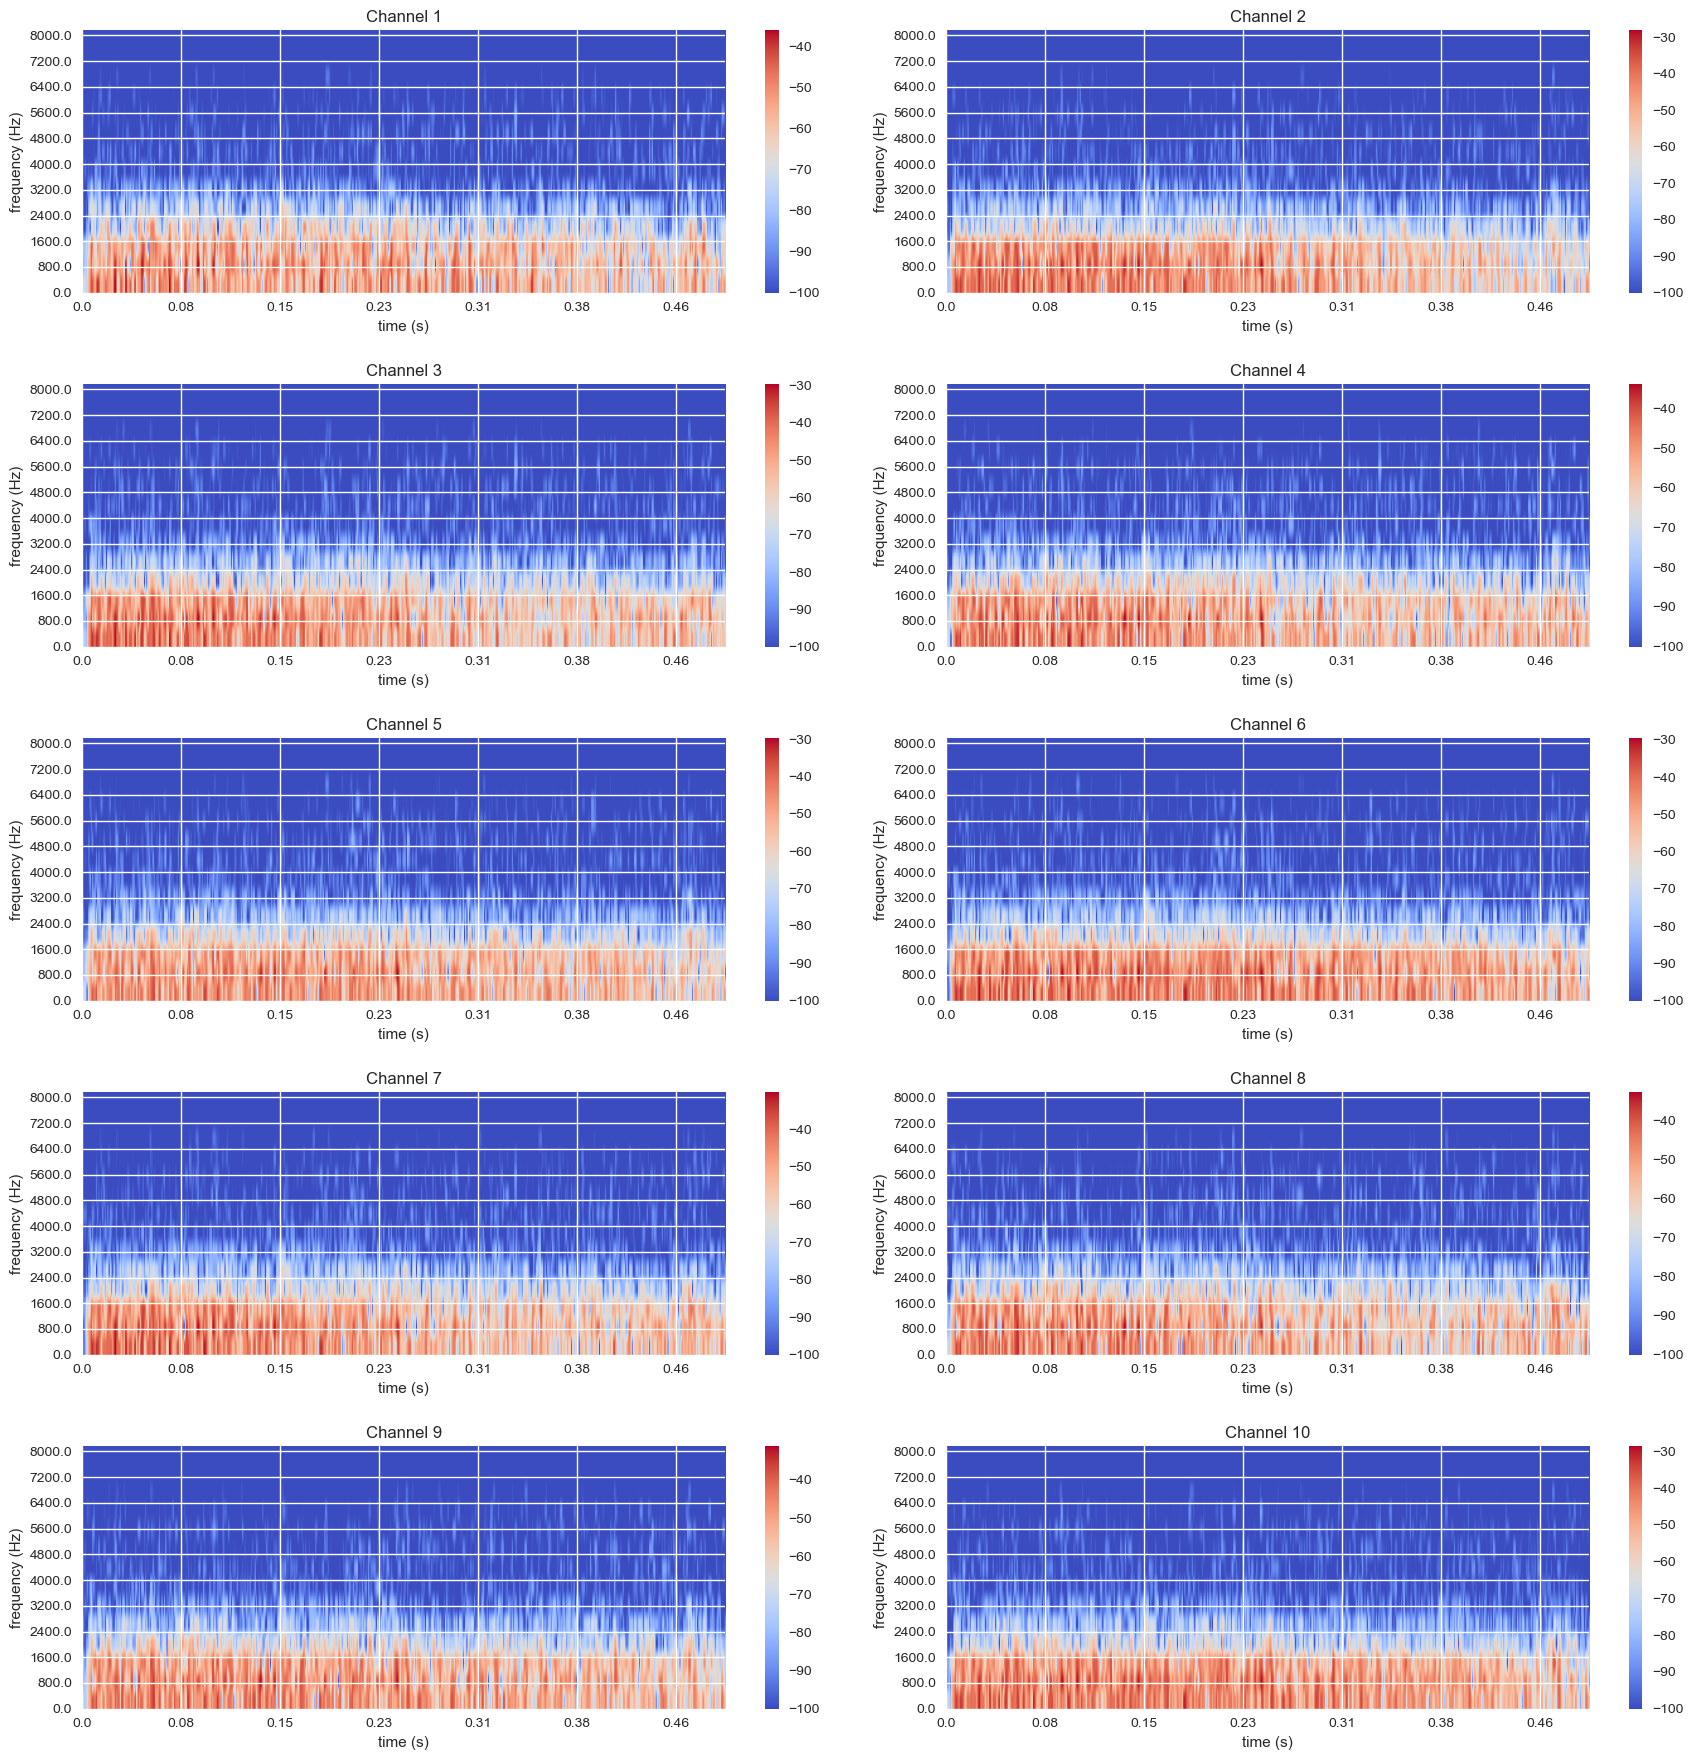

In [55]:
# plot the first 10 frames (spectrograms)
plt.figure(figsize=(18, 18))
NFFT = 1024
freq_bins = np.arange(0, NFFT / 2 - 1)
time_frames = np.arange(0, intensity.shape[0])
intensity_db = librosa.amplitude_to_db(intensity)
f_plot = np.fft.rfftfreq(NFFT, 1 / fs)[1:-1]
f_plot = np.round(f_plot / 100) * 100
t_plot = np.linspace(0, signals_train.shape[-1] / fs, intensity.shape[0]).round(2)
for i in range(0, 10):
    plt.subplot(5, 2, i + 1)
    plt.imshow(intensity_db[:, :, i], origin='lower', aspect='auto', cmap='coolwarm',
               extent=[time_frames[0], time_frames[-1], freq_bins[0], freq_bins[-1]])
    plt.xticks(np.arange(0, intensity.shape[0], 2), t_plot[0::int(len(t_plot) / 5)])
    plt.yticks(np.arange(0, NFFT / 2 - 1, 50), f_plot[0::int(len(f_plot) / 10)])
    plt.colorbar()
    plt.xlabel('time (s)')
    plt.ylabel('frequency (Hz)')
    plt.title('Channel ' + str(i + 1))
plt.tight_layout()
plt.show()

### Sound intensity features extraction for the whole dataset

In [64]:
features_shape = (14, 511, 10)  # (num_frames, num_freq_bins, num_channels)
# Init intensity
intensity_container = np.zeros([N_simulations_train, features_shape[0], features_shape[1], features_shape[2]])
# Extract SI features
for i in tqdm(range(0, N_simulations_train)):
    intensity_container[i, :, :, :] = extract_features(signals_train[i])

100%|██████████| 2000/2000 [00:25<00:00, 77.60it/s] 


In [65]:
# Init intensity
intensity_container_valid = np.zeros([N_simulations_valid, features_shape[0], features_shape[1], features_shape[2]])
# Extract SI features
for i in tqdm(range(0, N_simulations_valid)):
    intensity_container_valid[i, :, :, :] = extract_features(signals_valid[i])

100%|██████████| 600/600 [00:07<00:00, 75.20it/s] 


In [59]:
# Init intensity
intensity_container_test = np.zeros([N_simulations_test, features_shape[0], features_shape[1], features_shape[2]])
# Extract SI features
for i in tqdm(range(0, N_simulations_test)):
    intensity_container_test[i, :, :, :] = extract_features(signals_test[i])

100%|██████████| 100/100 [00:01<00:00, 57.84it/s]


## Neural network model

The neural network model is composed of 2 convolutional layers with 64 filters of size 3x3, each of which is followed by a a ReLU activation function and a batch normalization layer. The second "convolutional block" is followed by a dropout layer with a rate of 0.5.

Dropout is a regularization technique that consists of randomly setting to zero a fraction rate of the input units of the layer during training. This helps prevent overfitting.

The final three blocks in the network are fully connected (FC) layers with 512, 512 and `N_classes` neurons, respectively. The first two FC layers are followed by a ReLU activation function and a dropout layer. The last layer is a softmax layer that outputs a probability distribution over the `N_classes` classes.

In [67]:
filters = 64
kernel_size = (3, 3)
strides = (1, 1)
input_shape = (14, 511, 10)
rate = 0.5
K = N_classes

model = keras.Sequential([
    # input layer (14 * 511 * 10) (convolutional layers + batch normalization (BN) w ReLU)
    keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, input_shape=input_shape,
                        activation='relu', name='conv1'),
    keras.layers.BatchNormalization(name='bn1'),

    # 2nd convolutional layers + batch normalization (BN) w ReLU
    keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, activation='relu', name='conv2'),
    keras.layers.BatchNormalization(name='bn2'),
    # dropout procedure with rate 0.5
    tf.keras.layers.Dropout(rate, name='dn1'),

    # 1st fully connected layer w ReLU & dropout procedure with rate 0.5
    keras.layers.Flatten(name='flatten'),
    tf.keras.layers.Dense(512, activation='relu', name='fc1'),
    tf.keras.layers.Dropout(rate, name='dn2'),

    # 2nd fully connected layer w ReLU & dropout procedure with rate 0.5
    tf.keras.layers.Dense(512, activation='relu', name='fc2'),
    tf.keras.layers.Dropout(rate, name='dn3'),

    # Output layer
    tf.keras.layers.Dense(K, activation='softmax', name='output'),
])
model.name = 'DOA_CNN'
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 12, 509, 64)       5824      
                                                                 
 bn1 (BatchNormalization)    (None, 12, 509, 64)       256       
                                                                 
 conv2 (Conv2D)              (None, 10, 507, 64)       36928     
                                                                 
 bn2 (BatchNormalization)    (None, 10, 507, 64)       256       
                                                                 
 dn1 (Dropout)               (None, 10, 507, 64)       0         
                                                                 
 flatten (Flatten)           (None, 324480)            0         
                                                                 
 fc1 (Dense)                 (None, 512)              

Before we start training we need to define the optimizer, the loss function and the metrics we want to monitor during training. We will use the Adam optimizer with a learning rate of 1e-5. The loss function is the categorical cross-entropy and the metric we will monitor is the accuracy.

### What is the categorical cross-entropy loss function?

The categorical cross-entropy loss function is used when the output is a probability distribution over the `N_classes` classes. It is defined as:

$$
\mathcal{L} = - \sum_{i=1}^{N_{samples}} \sum_{j=1}^{N_{classes}} y_{ij} \log(\hat{y}_{ij})
$$

where $y_{ij}$ is the target probability of the $i$-th sample belonging to the $j$-th class and $\hat{y}_{ij}$ is the predicted probability of the $i$-th sample belonging to the $j$-th class. In practice the target probabilities are [one-hot encoded vectors]( https://en.wikipedia.org/wiki/One-hot).


### What is the accuracy metric?

The accuracy metric is defined as the number of correct predictions divided by the total number of predictions. It is computed as

$$
\text{accuracy} = \frac{\text{number of correct predictions}}{\text{total number of predictions}}
$$


### What is the Adam optimizer?

The Adam optimizer is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications. It is an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments.

It is defined as:

$$
\begin{align}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta_t &= \theta_{t-1} - \frac{\alpha \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{align}
$$

where $m_t$ and $v_t$ are the first and second moment estimates, respectively, $\hat{m}_t$ and $\hat{v}_t$ are the bias-corrected first and second moment estimates, respectively, $\alpha$ is the learning rate, $\beta_1$ and $\beta_2$ are the exponential decay rates for the first and second moment estimates, respectively, $\epsilon$ is a small constant for numerical stability, and $\theta_t$ are the model parameters.






In [75]:
# Compile
learning_rate = 1e-5
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [76]:
# Callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [
    model_checkpoint_callback,
    tf.keras.callbacks.EarlyStopping(patience=25, monitor='accuracy', mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1)
]

In [66]:
# Shuffling the features
(intensity_container, doa_encodings_train) = shuffle(intensity_container, doa_encodings_train)
(intensity_container_val, doa_encodings_valid) = shuffle(intensity_container_valid, doa_encodings_valid)

### Finally we train the model
Run the cell below to start training the model. The training will stop automatically when the validation accuracy stops improving. The best model will be saved in the file `best_model`.

In [77]:
history = model.fit(intensity_container, doa_encodings_train,
                    validation_data=(intensity_container_val, doa_encodings_valid), epochs=400, callbacks=callbacks)

Epoch 1/400
63/63 [==============================] - 224s 3s/step - loss: 2.7789 - accuracy: 0.0710 - val_loss: 2.4849 - val_accuracy: 0.0833 - lr: 1.0000e-05
Epoch 2/400
15/63 [======>.......................] - ETA: 2:24 - loss: 2.5413 - accuracy: 0.1042

KeyboardInterrupt: 

### Plotting the training history
The cell below plots the training and validation accuracy and loss as a function of the training epochs. The training accuracy and loss are plotted in blue and the validation accuracy and loss are plotted in orange.

In [ ]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# Model Inference: Predicting the DOA of new array responses

### Loading the best model
The cell below loads the best model that was saved during training. You can now use the model to predict the DOA of a new RIR. Skip to this cell if you have already trained the model and saved the best model.

In [ ]:
model.load_weights('best_model')

# Predicting the DOA of a new RIR

Now that we have trained the model we can use it to predict the DOA of a new array response. Before we do that though, let's compare to a baseline. The baseline is the Steered Response Power Phase Transform (SRP-PHAT) algorithm. The SRP-PHAT algorithm is a well known algorithm for DOA estimation. It is based on the Steered Response Power (SRP) algorithm and the Phase Transform (PHAT) algorithm. The SRP-PHAT algorithm is a computationally efficient algorithm that is used in many applications such as speech enhancement, speaker localization, and acoustic echo cancellation. The SRP-PHAT algorithm is described in the paper [A High-Accuracy, Low-Latency Technique for Talker Localization in Reverberant Environments Using Microphone Arrays](http://www.glat.info/ma/av16.3/2000-DiBiaseThesis.pdf). It can be defined as:

$$
\hat{\theta} = \arg \max_{\theta} \frac{1}{N} \sum_{n=1}^N \frac{1}{P} \sum_{p=1}^P \left| \sum_{m=1}^M \mathbf{a}_m e^{j2\pi \frac{d_m \sin \theta}{c} \Delta f} \right|^2
$$

where $\hat{\theta}$ is the estimated DOA, $\theta$ is the true DOA, $N$ is the number of snapshots, $P$ is the number of sensors, $M$ is the number of sources, $\mathbf{a}_m$ is the steering vector of the $m$th source, $d_m$ is the distance between the $m$th source and the $p$th sensor, $c$ is the speed of sound, $\Delta f$ is the frequency resolution, and $j$ is the imaginary unit.

The PHase Transform (PHAT) is included when we normalise the right hand side with the sum of the squared magnitude of the steering vectors.

### Find DOA of test set with SRP-PHAT

In [168]:
# Find DOA of test set
nfft_size = 1024
freqs = np.fft.rfftfreq(nfft_size, 1 / fs)
srp_doa_pred = []
true_doas = []
pbar = tqdm(range(len(signals_test)))
for i in pbar:
    P_stft = librosa.stft(signals_test[i], n_fft=nfft_size, hop_length=nfft_size//2, win_length=nfft_size, window='hann')
    srp_doa_pred.append(srpDOA(P_stft, freqs, mic_positions[i].T))
    true_doas.append(one_hot_encoding_to_azimuth(doa_encodings_test[i], angular_resolution))

100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


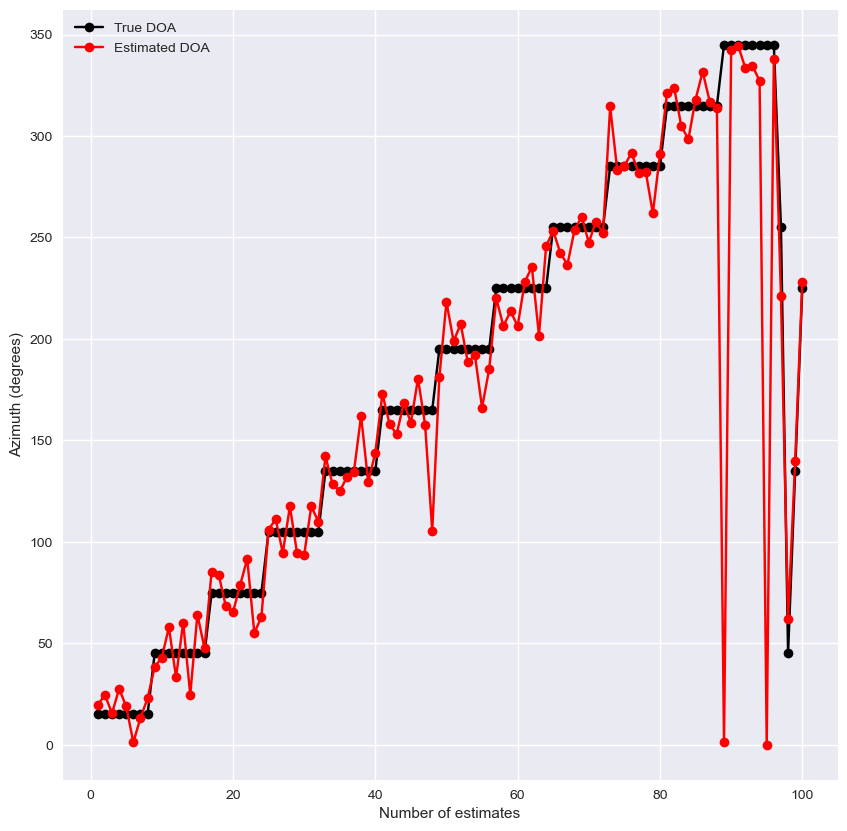

In [169]:
# plot estimated doas vs true doas
plt.figure(figsize=(8, 8))
N_estimates = len(true_doas)
estimate_no = np.arange(1, N_estimates + 1)
plt.plot(estimate_no, true_doas, '-o', label='True DOA', color='k')
plt.plot(estimate_no, srp_doa_pred, '-o', label='Estimated DOA SRP-PHAT', color='r')
plt.xlabel('Number of estimates')
plt.ylabel('Azimuth (degrees)')
plt.legend()
plt.show()

Now lets check out the neural network performance, we will use the same test set as we used for the SRP-PHAT algorithm.

### Find DOA of test set with neural network

In [17]:
# Find DOA of test set
net_doa_pred = []
true_doas = []
pbar = tqdm(range(len(signals_test)))
for i in pbar:
    net_doa_pred.append(one_hot_encoding_to_azimuth(model.predict(intensity_container_test[i])))
    true_doas.append(one_hot_encoding_to_azimuth(doa_encodings_test[i], angular_resolution))

In [18]:
# plot estimated doas vs true doas
plt.figure(figsize=(10, 10))
N_estimates = len(true_doas)
estimate_no = np.arange(1, N_estimates + 1)
plt.plot(estimate_no, true_doas, '-o', label='True DOA', color='k')
plt.plot(estimate_no, net_doa_pred, '-o', label='Estimated DOA NN', color='r')
plt.xlabel('Number of estimates')
plt.ylabel('Azimuth (degrees)')
plt.legend()
plt.show()

'/Users/xen/Documents/PhD Acoustics/Repositories/Advanced_Acoustics_ML_module/Advanced_Acoustics_ML_module'

In [ ]:
### Plot the RMS error for both the SRP-PHAT and the neural network
true_doas = np.deg2rad(np.array(true_doas))
net_doa_pred = np.deg2rad(np.array(net_doa_pred))
srp_doa_pred = np.deg2rad(np.array(srp_doa_pred))
rmse = lambda x, y: np.sqrt(np.mean((x - y)**2))

plt.figure(figsize=(10, 10))
plt.plot(estimate_no, rmse(true_doas, net_doa_pred), '-o', label='NN')
plt.plot(estimate_no, rmse(true_doas, srp_doa_pred), '-o', label='SRP-PHAT')
plt.xlabel('Number of estimates')
plt.ylabel('RMS error (rad)')
plt.legend()
plt.show()

# Conclusion

- What kind of conclusion did you arrive to?
- How did the neural network perform against the SRP-PHAT method?
- Did you manage to get a better performance than the SRP-PHAT method?
- What can you change to improve the performance of the neural network?
- What other methods can you use to improve the performance of the neural network?
- What other datasets can you use to train the neural network?
- What parameters in the room simulation can you change to improve the performance of the neural network?

Feel free to experiment with the code and see if you can improve the performance of the neural network.

# References

- [Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. Deep learning. *MIT press*, 2016.](http://www.deeplearningbook.org/)

- [Bishop, C. M., & Nasrabadi, N. M. (2006). Pattern recognition and machine learning (Vol. 4, No. 4, p. 738). *New York: springer*.](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book)

-  [Scheibler, R., Bezzam, E., & Dokmanić, I. (2018, April). Pyroomacoustics: A python package for audio room simulation and array processing algorithms. In *2018 IEEE international conference on acoustics, speech and signal processing (ICASSP)* (pp. 351-355). IEEE.]( https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.html).

- [Allen, Jont B., and David A. Berkley (1979). Image method for efficiently simulating small‐room acoustics. *The Journal of the Acoustical Society of America* 65.4 : 943-950.](https://pubs.aip.org/asa/jasa/article/65/4/943/765693/Image-method-for-efficiently-simulating-small-room)

- [De Sena, Enzo, et al (2015). On the modeling of rectangular geometries in room acoustic simulations. *IEEE/ACM Transactions on Audio, Speech, and Language Processing* 23.4 : 774-786.](https://ieeexplore.ieee.org/abstract/document/7045580?casa_token=KD9YBfkWnIEAAAAA:L4lHeM6mttebMUItXfMMAvYaoeb71nuWpoVWkCY-0Waspy8fgNCKoWpYQyBs09X_oxXBgJPTjQ)

- [Liu, N., Chen, H., Songgong, K., & Li, Y. (2021). Deep learning assisted sound source localization using two orthogonal first-order differential microphone arrays. *The Journal of the Acoustical Society of America*, 149(2), 1069-1084.](https://www.amazon.com/Deep-Learning-Audio-Signal-Processing/dp/1491984456)

- [DiBiase, J. H. (2000). A high-accuracy, low-latency technique for talker localization in reverberant environments using microphone arrays. *Brown University*.](http://www.glat.info/ma/av16.3/2000-DiBiaseThesis.pdf).
